# Instalação de bibliotecas no ambiente do Sage Maker

In [1]:
!pip install -U pip
!pip install sagemaker==2.15.3
!pip install boto3==1.16.2
!pip install pandas==1.0.1
!pip install numpy==1.18.1
!pip install matplotlib==3.3.3
!pip install scikit-learn==0.24.0

  Using cached pip-21.0.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.3.3
    Uninstalling pip-20.3.3:
      Successfully uninstalled pip-20.3.3
     |████████████████████████████████| 310 kB 17.3 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.15.3-py2.py3-none-any.whl size=433930 sha256=feefe33d943e2622f431b7c707e047727a1bcd13001b11d4077b95d77f67ab18
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7f/61/00/79808d56a79af25eeb721c35bcd75f4a695092cac8eb2668ab
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.24.1
    Uninstalling sagemaker-2.24.1:
      Successfully uninstalled sagemaker-2.24.1
     |████████████████████████████████| 129 kB 17.2 MB/s e

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.1
    Uninstalling matplotlib-3.2.1:
      Successfully uninstalled matplotlib-3.2.1
     |████████████████████████████████| 22.2 MB 10.7 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


# Importação de bibiotecas e declaração de constantes

In [2]:
# Importação do Boto3 e criação da sessão
import boto3

In [3]:
sessao_boto = boto3.Session(region_name='us-east-1')

In [4]:
# Colocar a role de execução em uma constante
from sagemaker import get_execution_role

In [5]:
ROLE = get_execution_role()

In [6]:
print(ROLE)

arn:aws:iam::962752222089:role/service-role/AWSGlueServiceSageMakerNotebookRole-gdelt


In [7]:
# Importar o Sage Maker SDK e criar uma sessão
# realizando a referencia ao Boto3
import sagemaker

In [8]:
sessao_sagemaker_sdk = \
    sagemaker.Session(boto_session=sessao_boto)

In [9]:
sessao_sagemaker_boto \
    = boto3.Session().client('sagemaker')

In [10]:
BUCKET ='sagemaker-alura-engenharia-machine-learning'

PREFIXO_DADOS = 'dados'

PREFIXO_MODELOS = 'modelos'

REGIAO = boto3.Session().region_name

SEMENTE = 42

In [11]:
import sys

sys.path.append("./")

import io
import time

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from time import strftime, gmtime

# Carga de dados no Amazon S3

In [12]:
# Vamos colocar os caminhos em um dicionário
# apenas para manter a simplicidade e a consistência
# dos caminhos. Em caso de mudança, essa será refletida
# em todas as partes do script.

dict_caminho_dados = {
    "treino": "dados/df_bytebank_treino.csv",
    "teste": "dados/df_bytebank_teste.csv",
    "validacao": "dados/df_bytebank_validacao.csv",    
}

In [13]:
dict_caminho_dados['treino']

'dados/df_bytebank_treino.csv'

In [14]:
# Agora vamos usar a nossa sessão do Boto3 (boto_session)
# invocando o recurso S3 e em seguida passar o caminho 
# do nossos arquivos localmente, passando o caminho desses
# arquivos que constam em nosso repositorio, e realizar 
# o upload desses arquivos para o S3

from boto3.s3.transfer import TransferConfig
gigabytes = 1024 ** 3
configuracao = TransferConfig(multipart_threshold=5*gigabytes)


# Vamos usar uma função para não repetir o mesmo código
def upload_arquivos_para_s3(caminho_s3,
                            caminho_local,
                            bucket=BUCKET,
                            prefix_data=PREFIXO_DADOS,
                            configuracao=configuracao,
                            sessao=sessao_boto
                           ):
    sessao.resource('s3').Bucket(bucket).\
        Object(os.path.join(prefix_data, caminho_s3))\
        .upload_file(caminho_local, Config=configuracao)

In [15]:
upload_arquivos_para_s3(caminho_s3='treino/treino.csv',
                       caminho_local=dict_caminho_dados['treino'])

In [16]:
upload_arquivos_para_s3(caminho_s3='teste/teste.csv',
                       caminho_local=dict_caminho_dados['teste'])

In [17]:
upload_arquivos_para_s3(caminho_s3='validacao/validacao.csv',
                       caminho_local=dict_caminho_dados['validacao'])

# Imagens pré-construídas do Sage Maker

In [18]:
# Buscar no registro a URI da imagem, e 
# criar a referencia do container que sera construido
from sagemaker.image_uris import retrieve

In [19]:
container = retrieve('xgboost',
                     region=REGIAO,
                     version='1.0-1')

In [20]:
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

# Definição de caminhos dos objetos e parâmetros de treinamento

In [21]:
print(BUCKET)

sagemaker-alura-engenharia-machine-learning


In [22]:
print(REGIAO)

us-east-1


In [23]:
print(PREFIXO_MODELOS)

modelos


In [24]:
print(PREFIXO_DADOS)

dados


In [25]:
s3_caminho_output_modelo \
    = f'https://{BUCKET}.s3.{REGIAO}.amazonaws.com/{PREFIXO_MODELOS}/'

print(f'S3 Caminho Output Modelo: {s3_caminho_output_modelo}')

S3 Caminho Output Modelo: https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/modelos/


In [26]:
s3_uri_input_treino \
    = f'https://{BUCKET}.s3.{REGIAO}.amazonaws.com/{PREFIXO_DADOS}/treino/'

print(f'S3 Caminho Input Treino: {s3_uri_input_treino}')

S3 Caminho Input Treino: https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/dados/treino/


In [27]:
s3_uri_input_teste \
    = f'https://{BUCKET}.s3.{REGIAO}.amazonaws.com/{PREFIXO_DADOS}/teste/'

print(f'S3 Caminho Input Teste: {s3_uri_input_teste}')

S3 Caminho Input Teste: https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/dados/teste/


# Definição de configurações do job de treinamento

In [28]:
s3_uri_input_teste

'https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/dados/teste/'

In [29]:
parametros_comuns_treinamento = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": ROLE,
    "OutputDataConfig": {
        "S3OutputPath": s3_caminho_output_modelo
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth": "7",
        "subsample": "0.8",
        "num_round": "10",        
        "eta": "0.3",
        "eval_metric": "error",        
        "silent":"0",
        "one_drop":"1",
        "seed": str(SEMENTE),        
        "objective": "binary:hinge"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_uri_input_treino,
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_uri_input_teste,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        }
    ]
}

In [30]:
nome_job_treinamento \
    = 'bytebankPythonBoto' + strftime("%Y%m%d%H%M%S", gmtime())

print(f"Nome do Job de treinamento: {nome_job_treinamento}")

Nome do Job de treinamento: bytebankPythonBoto20210215212527


In [31]:
s3_caminho_dados_treinamento \
    = parametros_comuns_treinamento['InputDataConfig'][0]['DataSource']['S3DataSource']['S3Uri']

print(f"\nDados de treinamento no S3: {s3_caminho_dados_treinamento}")


Dados de treinamento no S3: https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/dados/treino/


In [32]:
s3_caminho_dados_teste \
    = parametros_comuns_treinamento['InputDataConfig'][1]['DataSource']['S3DataSource']['S3Uri']

print(f"\nDados de teste no S3: {s3_caminho_dados_teste}")


Dados de teste no S3: https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/dados/teste/


In [33]:
s3_caminho_modelo \
    = parametros_comuns_treinamento['OutputDataConfig']['S3OutputPath']

print(f"\nPasta no S3 para serialização do modelo: {s3_caminho_modelo}")


Pasta no S3 para serialização do modelo: https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/modelos/


In [34]:
nome_job_treinamento

'bytebankPythonBoto20210215212527'

In [35]:
import copy 

parametros_job_treinamento = copy.deepcopy(parametros_comuns_treinamento)

parametros_job_treinamento['TrainingJobName'] = nome_job_treinamento

parametros_job_treinamento['ResourceConfig']['InstanceCount'] = 1

# Treinamento e criação do modelo

In [36]:
parametros_job_treinamento

{'AlgorithmSpecification': {'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
  'TrainingInputMode': 'File'},
 'RoleArn': 'arn:aws:iam::962752222089:role/service-role/AWSGlueServiceSageMakerNotebookRole-gdelt',
 'OutputDataConfig': {'S3OutputPath': 'https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/modelos/'},
 'ResourceConfig': {'InstanceCount': 1,
  'InstanceType': 'ml.m4.xlarge',
  'VolumeSizeInGB': 5},
 'HyperParameters': {'max_depth': '7',
  'subsample': '0.8',
  'num_round': '10',
  'eta': '0.3',
  'eval_metric': 'error',
  'silent': '0',
  'one_drop': '1',
  'seed': '42',
  'objective': 'binary:hinge'},
 'StoppingCondition': {'MaxRuntimeInSeconds': 600},
 'InputDataConfig': [{'ChannelName': 'train',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/dados/treino/',
     'S3DataDistributionType': 'Fully

In [37]:
# Criação do job de treinamento
sessao_sagemaker_boto.create_training_job(**parametros_job_treinamento)

status = \
    sessao_sagemaker_boto.describe_training_job(
    TrainingJobName=nome_job_treinamento)['TrainingJobStatus']
print(f'Status do Treinamento: {status}')

# Status do Job de treinamento via waiter
sessao_sagemaker_boto.get_waiter('training_job_completed_or_stopped')\
    .wait(TrainingJobName=nome_job_treinamento)

status = \
    sessao_sagemaker_boto.describe_training_job(
    TrainingJobName=nome_job_treinamento)['TrainingJobStatus']
print(f'Treinamento finalizado: {status}')

# "Monitoramento" do status do Job de treinamento
if status == 'Failed':
    message = \
        sessao_sagemaker_boto\
        .describe_training_job(
            TrainingJobName=nome_job_treinamento)['FailureReason']
    print(f'Erro no treinamento devido ao problema: {message}')
    raise Exception('O treinamento do modelo falhou')

Status do Treinamento: InProgress
Treinamento finalizado: Completed


In [38]:
# Definição do nome do modelo 
nome_modelo = nome_job_treinamento + 'Model'

# Informações sobre o job de treinamento
info \
    = sessao_sagemaker_boto.describe_training_job(
    TrainingJobName=nome_job_treinamento)

# Informações onde os artefatos do modelo serão salvos
dados_modelo = info['ModelArtifacts']['S3ModelArtifacts']

In [39]:
print(dados_modelo)

https://sagemaker-alura-engenharia-machine-learning.s3.us-east-1.amazonaws.com/modelos/bytebankPythonBoto20210215212527/output/model.tar.gz


In [40]:
# Definição do container e de onde 
# o modelo sera serializado
container_primario = {
    'Image': container,
    'ModelDataUrl': dados_modelo
}

In [41]:
nome_modelo

'bytebankPythonBoto20210215212527Model'

In [42]:
# Criacão do modelo no registro
create_model_response \
    = sessao_sagemaker_boto.create_model(
    ModelName = nome_modelo,
    ExecutionRoleArn = ROLE,
    PrimaryContainer =  container_primario
)

In [43]:
print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:962752222089:model/bytebankpythonboto20210215212527model


# Configuração do endpoint

In [44]:
# Nome da configuracao do endpoint
nome_configuracao_endpoint \
    = 'bytebankXGBEndpointConfig' + strftime("%Y%m%d%H%M%S", gmtime())
print(f'Nome da Configuração do Endpoint: {nome_configuracao_endpoint}')

Nome da Configuração do Endpoint: bytebankXGBEndpointConfig20210215213038


In [45]:
nome_modelo

'bytebankPythonBoto20210215212527Model'

In [46]:
# Criação da configuracao do endpoint
create_endpoint_config_response \
    = sessao_sagemaker_boto.create_endpoint_config(
        EndpointConfigName = nome_configuracao_endpoint,
        ProductionVariants=[{
            'InstanceType':'ml.m4.xlarge',
            'InitialVariantWeight':1,
            'InitialInstanceCount':1,
            'ModelName':nome_modelo,
            'VariantName':'TodoTrafego'}])

print("\nEndpoint configurado no Arn: " + create_endpoint_config_response['EndpointConfigArn'])


Endpoint configurado no Arn: arn:aws:sagemaker:us-east-1:962752222089:endpoint-config/bytebankxgbendpointconfig20210215213038


# Criação e deployment do modelo no Endpoint

In [47]:
nome_endpoint \
    = 'bytebankXGBEndpoint' + strftime("%Y%m%d%H%M%S", gmtime())
print(f'Nome do Endpoint: {nome_endpoint}')

Nome do Endpoint: bytebankXGBEndpoint20210215213041


In [48]:
print(nome_configuracao_endpoint)

bytebankXGBEndpointConfig20210215213038


In [49]:
create_endpoint_response \
    = sessao_sagemaker_boto.create_endpoint(
        EndpointName=nome_endpoint,
        EndpointConfigName=nome_configuracao_endpoint)

print(create_endpoint_response['EndpointArn'])

arn:aws:sagemaker:us-east-1:962752222089:endpoint/bytebankxgbendpoint20210215213041


In [50]:
resp = sessao_sagemaker_boto.describe_endpoint(EndpointName=nome_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(20)
    resp = sessao_sagemaker_boto.describe_endpoint(EndpointName=nome_endpoint)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:962752222089:endpoint/bytebankxgbendpoint20210215213041
Status: InService


# Chamada do modelo no endpoint

In [51]:
dict_caminho_dados['validacao']

'dados/df_bytebank_validacao.csv'

In [52]:
df_bytebank_validacao \
    = pd.read_csv(dict_caminho_dados['validacao'])
df_bytebank_validacao.head(5)

,INADIMPLENTE,CREDITO_CONCEDIDO,GENERO,ESCOLARIDADE,ESTADO_CIVIL,IDADE,ATRASO_PARCELA_M_0,ATRASO_PARCELA_M_2,ATRASO_PARCELA_M_3,ATRASO_PARCELA_M_4,...,SALDO_PAGO_PARCELA_3,SALDO_PAGO_PARCELA_4,SALDO_PAGO_PARCELA_5,SALDO_PAGO_PARCELA_6,VALOR_PAGAMENTO_ANTERIOR_1,VALOR_PAGAMENTO_ANTERIOR_2,VALOR_PAGAMENTO_ANTERIOR_3,VALOR_PAGAMENTO_ANTERIOR_4,VALOR_PAGAMENTO_ANTERIOR_5,VALOR_PAGAMENTO_ANTERIOR_6
0,0,10000,1,2,2,24,2,0,0,0,...,4810,7546,9260,10000,3000,2000,3000,2000,1000,0
1,0,360000,1,2,1,45,2,2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
2,0,280000,2,1,2,28,-1,-1,-1,0,...,10002,13476,23572,14603,3658,10020,10000,11000,14603,3819
3,1,52743,1,1,2,47,0,0,0,0,...,13507,11462,8191,9460,1091,10505,1603,658,3783,1790
4,1,243160,1,2,2,40,2,0,0,0,...,241034,240190,238301,238645,9454,9366,12440,9034,6587,11570


In [53]:
y_validacao \
    = np.array(df_bytebank_validacao['INADIMPLENTE'])

In [54]:
y_validacao

array([0, 0, 0, ..., 1, 1, 1])

In [55]:
del df_bytebank_validacao['INADIMPLENTE']

In [56]:
df_bytebank_validacao.head(3)

,CREDITO_CONCEDIDO,GENERO,ESCOLARIDADE,ESTADO_CIVIL,IDADE,ATRASO_PARCELA_M_0,ATRASO_PARCELA_M_2,ATRASO_PARCELA_M_3,ATRASO_PARCELA_M_4,ATRASO_PARCELA_M_5,...,SALDO_PAGO_PARCELA_3,SALDO_PAGO_PARCELA_4,SALDO_PAGO_PARCELA_5,SALDO_PAGO_PARCELA_6,VALOR_PAGAMENTO_ANTERIOR_1,VALOR_PAGAMENTO_ANTERIOR_2,VALOR_PAGAMENTO_ANTERIOR_3,VALOR_PAGAMENTO_ANTERIOR_4,VALOR_PAGAMENTO_ANTERIOR_5,VALOR_PAGAMENTO_ANTERIOR_6
0,10000,1,2,2,24,2,0,0,0,0,...,4810,7546,9260,10000,3000,2000,3000,2000,1000,0
1,360000,1,2,1,45,2,2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
2,280000,2,1,2,28,-1,-1,-1,0,0,...,10002,13476,23572,14603,3658,10020,10000,11000,14603,3819


In [57]:
colunas = [
    'CREDITO_CONCEDIDO',
    'GENERO',
    'ESCOLARIDADE',
    'ESTADO_CIVIL',
    'IDADE',
    'ATRASO_PARCELA_M_0',
    'ATRASO_PARCELA_M_2',
    'ATRASO_PARCELA_M_3',
    'ATRASO_PARCELA_M_4',
    'ATRASO_PARCELA_M_5',
    'ATRASO_PARCELA_M_6',
    'SALDO_PAGO_PARCELA_1',
    'SALDO_PAGO_PARCELA_2',
    'SALDO_PAGO_PARCELA_3',
    'SALDO_PAGO_PARCELA_4',
    'SALDO_PAGO_PARCELA_5',
    'SALDO_PAGO_PARCELA_6',
    'VALOR_PAGAMENTO_ANTERIOR_1',
    'VALOR_PAGAMENTO_ANTERIOR_2',
    'VALOR_PAGAMENTO_ANTERIOR_3',
    'VALOR_PAGAMENTO_ANTERIOR_4',
    'VALOR_PAGAMENTO_ANTERIOR_5',
    'VALOR_PAGAMENTO_ANTERIOR_6',
]

df_bytebank_validacao['payload'] \
    = df_bytebank_validacao[colunas].apply(
        lambda row: ','.join(
            row.values.astype(str)), axis=1)

In [58]:
df_bytebank_validacao.head(3)

,CREDITO_CONCEDIDO,GENERO,ESCOLARIDADE,ESTADO_CIVIL,IDADE,ATRASO_PARCELA_M_0,ATRASO_PARCELA_M_2,ATRASO_PARCELA_M_3,ATRASO_PARCELA_M_4,ATRASO_PARCELA_M_5,...,SALDO_PAGO_PARCELA_4,SALDO_PAGO_PARCELA_5,SALDO_PAGO_PARCELA_6,VALOR_PAGAMENTO_ANTERIOR_1,VALOR_PAGAMENTO_ANTERIOR_2,VALOR_PAGAMENTO_ANTERIOR_3,VALOR_PAGAMENTO_ANTERIOR_4,VALOR_PAGAMENTO_ANTERIOR_5,VALOR_PAGAMENTO_ANTERIOR_6,payload
0,10000,1,2,2,24,2,0,0,0,0,...,7546,9260,10000,3000,2000,3000,2000,1000,0,"10000,1,2,2,24,2,0,0,0,0,0,223,3035,4810,7546,..."
1,360000,1,2,1,45,2,2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,"360000,1,2,1,45,2,2,-2,-2,-2,-2,2500,0,0,0,0,0..."
2,280000,2,1,2,28,-1,-1,-1,0,0,...,13476,23572,14603,3658,10020,10000,11000,14603,3819,"280000,2,1,2,28,-1,-1,-1,0,0,-1,3678,1829,1000..."


In [59]:
cliente_runtime = boto3.client('runtime.sagemaker')

In [60]:
cliente_runtime

In [61]:
df_bytebank_validacao['payload'][0]

'10000,1,2,2,24,2,0,0,0,0,0,223,3035,4810,7546,9260,10000,3000,2000,3000,2000,1000,0'

In [62]:
y_pred = [] 

for index, row in df_bytebank_validacao.iterrows():
    body = row.payload
    
    response = cliente_runtime.invoke_endpoint(
        EndpointName = nome_endpoint,
        ContentType = 'text/csv',
        Body = body,
    )
    
    result = response['Body'].read().decode('utf-8')
    y_pred.append(result)

In [63]:
# Apenas alguns rótulos para geração dos gráficos
rotulos_classes = ['adimplente', 'inadimplente']

# Vamos considerar como y sendo a nossa base de validação e
# y_pred como resultado dos dados previstos pelo modelo
y = np.array(y_validacao)
y_pred = np.array(y_pred)

y = y.astype(float).astype(int)
y_pred = y_pred.astype(float).astype(int)

In [64]:
df_bytebank_validacao.shape

(6990, 24)

# Relatório de Classificação

In [65]:
pd.DataFrame(
    classification_report(
        y,
        y_pred,
        target_names=rotulos_classes,
        output_dict=True))

,adimplente,inadimplente,accuracy,macro avg,weighted avg
precision,0.767414,0.753909,0.760372,0.760662,0.760602
recall,0.741051,0.779353,0.760372,0.760202,0.760372
f1-score,0.754002,0.766420,0.760372,0.760211,0.760266
support,3464.000000,3526.000000,0.760372,6990.000000,6990.000000


# Métricas de Classificação

In [66]:
def metricas_classificacao(y,
                               y_pred,
                               class_labels=rotulos_classes):
    accuracy = accuracy_score(y , y_pred)
    print(f"Acurácia: {round(accuracy, 2)* 100} %")

In [67]:
metricas_classificacao(y, y_pred)

Acurácia: 76.0 %


# Matriz de Confusão

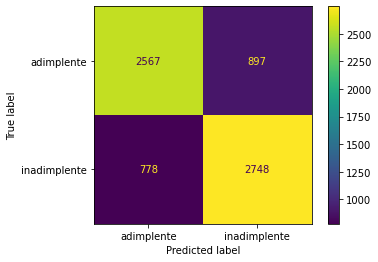

In [68]:
cm = confusion_matrix(y,
                      y_pred)

cm_display = \
    ConfusionMatrixDisplay(cm,
                           display_labels=rotulos_classes).plot(values_format = '.0f')

# Script para fazer a chamada no endpoint

In [69]:
nome_endpoint

'bytebankXGBEndpoint20210215213041'

In [71]:
import boto3

runtime \
    = boto3.Session().client(
        service_name='sagemaker-runtime',
        region_name='us-east-1')

payload \
    = '140000,2,2,1,37,0,0,0,0,0,0,58081,51013,54343,27537,9751,12569,5000,5000,5000,3000,3000,5000'

response \
    = runtime.invoke_endpoint(
        EndpointName=nome_endpoint,
        ContentType='text/csv',
        Body=payload)

predicao = int(float((response['Body'].read().decode('UTF-8'))))
print(f'Crédito será inadimplente?: {predicao}')

Crédito será inadimplente?: 0


# Destruição dos artefatos construídos

In [72]:
response \
    = sessao_sagemaker_boto.delete_endpoint(
        EndpointName=nome_endpoint)
print(response)

{'ResponseMetadata': {'RequestId': 'beb3a783-61fc-475f-b82d-a7212df2d3ef', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'beb3a783-61fc-475f-b82d-a7212df2d3ef', 'content-type': 'application/x-amz-json-1.1', 'content-length': '0', 'date': 'Mon, 15 Feb 2021 21:41:16 GMT'}, 'RetryAttempts': 0}}


In [73]:
response \
    = sessao_sagemaker_boto.delete_endpoint_config(
        EndpointConfigName=nome_configuracao_endpoint)
print(response)

{'ResponseMetadata': {'RequestId': '79330ebc-4869-4a44-850c-d926f6abf426', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '79330ebc-4869-4a44-850c-d926f6abf426', 'content-type': 'application/x-amz-json-1.1', 'content-length': '0', 'date': 'Mon, 15 Feb 2021 21:41:16 GMT'}, 'RetryAttempts': 0}}


In [74]:
response \
    = sessao_sagemaker_boto.delete_model(
        ModelName=nome_modelo)
print(response)

{'ResponseMetadata': {'RequestId': 'c7f0cdd9-99e0-4cec-a8d8-e0317bd4f45a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c7f0cdd9-99e0-4cec-a8d8-e0317bd4f45a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '0', 'date': 'Mon, 15 Feb 2021 21:41:16 GMT'}, 'RetryAttempts': 0}}
